In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/train_images_list.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/all_qa_pairs.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/test_images_list.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data.csv
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/answer_space.txt
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1317.png
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image1268.png
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image745.png
/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/image883.png
/kaggle/input/visual-question-answering-computer-vision

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim import AdamW

In [7]:
train_path = r"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_train.csv"
eval_path = r"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/data_eval.csv"
image_path = r"/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images"

In [8]:
pre_dataset = pd.DataFrame(pd.read_csv(train_path))
pre_dataset

question        answer  \
0                     what is the object on the shelves           cup   
1                              how man chairs are there             6   
2           what is hanged to the right side of the bed       curtain   
3                      how many picture are on the wall             2   
4       what is the object on the floor behind the rack  room_divider   
...                                                 ...           ...   
9969                  what is to the right of the table       cabinet   
9970                     what is the colour of the lamp         black   
9971                            what is behind the lamp       curtain   
9972  what is the object close to the middle counter...         stove   
9973                            what is above the stove     microwave   

       image_id  
0      image100  
1      image888  
2     image1174  
3      image942  
4     image1220  
...         ...  
9969  image1349  
9970   image956  
9971  image1009  
9972   image908  
9973   image126  

[9974 rows x 3 columns]

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),

    #Thêm 1 vài bước xử lý ảnh để đa dạng hóa dữ liệu - Data Augmentation
    transforms.RandomRotation(30),  # Xoay ảnh ngẫu nhiên trong khoảng ±30 độ
    transforms.RandomHorizontalFlip(),  # Lật ngang ngẫu nhiên
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Điều chỉnh độ sáng, độ tương phản
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [10]:
import spacy
from collections import Counter

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
#Tokenizer sử dụng spacy
def spacy_tokenizer(text):
    tokens = []
    for token in nlp(text):
        if not token.is_punct and not token.is_space: # Nếu không phải là dấu câu hoặc là khoảng trống thì thêm vào tokens
            tokens.append(token.text.lower())
    return tokens # Trả về mảng có chứa các chữ trong câu

In [13]:
#Xây dựng vocab cho bài toán
def build_vocab(texts, min_freq = 1):
    """
    texts: danh sách các câu hỏi hoặc trả lời được đưa vào
    min_freq: Tần suất tối thiểu 1 chữ xuất hiện để đưa vào vocab
    """
    counter = Counter()
    for text in texts:
        counter.update(spacy_tokenizer(text)) #Counter để đếm xem 1 chữ xuất hiện bao nhiêu lần
    # print(counter)

    vocab = {}
    vocab["<unk>"] = 0  # Token unknown
    vocab["<pad>"] = 1  # Token padding
    vocab["<sos>"] = 2  # Start of sentence
    vocab["<eos>"] = 3  # End of sentence

    index = 4 #Bắt đầu từ 2 do 0 với 1 dành cho <UNK>, <PAD>
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = index
            index += 1
    # print(vocab)
    return vocab

In [14]:
dataframe = pd.DataFrame(pd.read_csv(train_path))
dataframe

question        answer  \
0                     what is the object on the shelves           cup   
1                              how man chairs are there             6   
2           what is hanged to the right side of the bed       curtain   
3                      how many picture are on the wall             2   
4       what is the object on the floor behind the rack  room_divider   
...                                                 ...           ...   
9969                  what is to the right of the table       cabinet   
9970                     what is the colour of the lamp         black   
9971                            what is behind the lamp       curtain   
9972  what is the object close to the middle counter...         stove   
9973                            what is above the stove     microwave   

       image_id  
0      image100  
1      image888  
2     image1174  
3      image942  
4     image1220  
...         ...  
9969  image1349  
9970   image956  
9971  image1009  
9972   image908  
9973   image126  

[9974 rows x 3 columns]

In [15]:
eval_dataframe = pd.DataFrame(pd.read_csv(eval_path))
eval_dataframe

question                      answer  \
0     what is the colour of the bag on the chair                        pink   
1                    what is at the right bottom                       table   
2                     what are found on the rack                         toy   
3                        what is left of printer                      mirror   
4               what is the colour of television                       black   
...                                          ...                         ...   
2489                 what is beneath the monitor                       paper   
2490                  what is the largest object                         bed   
2491        what is on the right side of the tap  bottle_of_hand_wash_liquid   
2492         how many lights are above the table                           3   
2493                        what is on the table             decorative_item   

       image_id  
0      image399  
1     image1341  
2     image1320  
3      image529  
4      image201  
...         ...  
2489   image528  
2490  image1077  
2491   image695  
2492   image875  
2493  image1377  

[2494 rows x 3 columns]

In [16]:
vocab_questions = build_vocab(dataframe['question'])
vocab_answers = build_vocab(dataframe['answer'])

In [17]:
# Kiểm tra một số từ trong vocab
print("Sample vocab from questions:")
for word, index in list(vocab_questions.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

print("\nSample vocab from answers:")
for word, index in list(vocab_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

Sample vocab from questions:
<unk>: 0
<pad>: 1
<sos>: 2
<eos>: 3
what: 4
is: 5
the: 6
object: 7
on: 8
shelves: 9

Sample vocab from answers:
<unk>: 0
<pad>: 1
<sos>: 2
<eos>: 3
cup: 4
6: 5
curtain: 6
2: 7
room_divider: 8
garbage_bin: 9


In [18]:
# Lấy kích thước của các vocab
questions_vocab_size = len(vocab_questions)
answers_vocab_size = len(vocab_answers)

In [19]:
idx2word_answers = {idx: word for word, idx in vocab_answers.items()} #Đây sẽ là phần đối chiếu từ 1 indice sang 1 từ

In [20]:
# Kiểm tra một số từ trong vocab
print("Sample vocab from questions:")
for word, index in list(idx2word_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

print("\nSample vocab from answers:")
for word, index in list(idx2word_answers.items())[:10]:  # Hiển thị 10 từ đầu tiên
    print(f"{word}: {index}")

Sample vocab from questions:
0: <unk>
1: <pad>
2: <sos>
3: <eos>
4: cup
5: 6
6: curtain
7: 2
8: room_divider
9: garbage_bin

Sample vocab from answers:
0: <unk>
1: <pad>
2: <sos>
3: <eos>
4: cup
5: 6
6: curtain
7: 2
8: room_divider
9: garbage_bin


In [21]:
#Hàm sẽ biến đổi 1 tensor chứa các indice chuyển sang thành 1 câu dựa trên idx2word_answers
def decode_answer(tensor, vocab_dict):
    return " ".join([vocab_dict[idx] for idx in tensor if idx not in {0, 1}])

In [22]:
def get_max_len(texts):
    max_len = 0
    for text in texts:
        tokens = spacy_tokenizer(text)
        if len(tokens) > max_len:
            max_len = len(tokens)
    return max_len

In [23]:
# len_max_question = get_max_len(dataframe['question'])
# len_max_answer = get_max_len(dataframe['response'])

len_max_question = 24
len_max_answer = 7

In [24]:
#Biến đổi từ 1 câu sang 1 tensor
def text_to_tensor(text, vocab, max_len):
    """
    text: câu hỏi
    vocab: từ điển các từ đã xuất hiện trong tập câu hỏi và câu trả lời
    max_len: chiều dài
    """
    tokens = spacy_tokenizer(text)
    tokens = ["<sos>"] + tokens + ["<eos>"]

    indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]

    # Điều chỉnh độ dài
    if len(indices) < max_len:  # Padding
        indices += [vocab["<pad>"]] * (max_len - len(indices))
    else:  # Truncate
        indices = indices[:max_len]

    return torch.tensor(indices, dtype=torch.long)

In [25]:
class VQADataset(Dataset):
    def __init__(self, csv_path, image_folder, transform=None):
        self.df = pd.read_csv(csv_path)
        self.df['image_id'] = self.df['image_id'] + '.png'  # Thêm phần mở rộng ảnh
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_folder, row['image_id'])
        question = text_to_tensor(row['question'], vocab_questions, len_max_question)
        answer = text_to_tensor(row['answer'], vocab_answers, len_max_answer)

        # Kiểm tra ảnh tồn tại không
        if os.path.exists(image_path):
            img = Image.open(image_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        else:
            img = torch.zeros((3, 224, 224))  # Ảnh placeholder nếu bị lỗi
            print(f"Ảnh không tồn tại: {image_path}")

        return img, question, answer

In [26]:
train_dataset = VQADataset(train_path, image_path, transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers = 4)
eval_dataset = VQADataset(eval_path, image_path, transform)
eval_loader = DataLoader(eval_dataset, batch_size=16, shuffle=True, num_workers = 4)

In [27]:
sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
sample_image, sample_question, sample_answer = train_dataset[sample_idx]

print(f"Sample index: {sample_idx}")
print(f"Question Tensor: {sample_question}")
print(f"Answer Tensor: {sample_answer}")
print(f"Image Shape: {sample_image.shape}")

Sample index: 4724
Question Tensor: tensor([  2,   4,   5,   6, 106,   7,   3,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1])
Answer Tensor: tensor([ 2, 38,  3,  1,  1,  1,  1])
Image Shape: torch.Size([3, 224, 224])


In [28]:
# Kiểm tra DataLoader: lấy một batch đầu tiên
for images, questions, answers in train_loader:
    print(f"Batch size: {images.shape}")  # Kiểm tra kích thước batch ảnh
    print(f"First Question Tensor: {questions[0]}")
    print(f"First Answer Tensor: {answers[0]}")
    break  # Dừng sau một batch để tránh in quá nhiều

Batch size: torch.Size([16, 3, 224, 224])
First Question Tensor: tensor([  2,   4,   5,   8,   6,  36,  18,  19,   6, 791,   3,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1])
First Answer Tensor: tensor([  2, 104,   3,   1,   1,   1,   1])


In [29]:
for images, questions, answers in eval_loader:
    print(f"Batch size: {images.shape}")  # Kiểm tra kích thước batch ảnh
    print(f"First Question Tensor: {questions[0]}")
    print(f"First Answer Tensor: {answers[0]}")
    break  # Dừng sau một batch để tránh in quá nhiều

Batch size: torch.Size([16, 3, 224, 224])
First Question Tensor: tensor([  2,  10,  21, 856,  13,  14,   3,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1])
First Answer Tensor: tensor([ 2, 53,  3,  1,  1,  1,  1])


In [30]:
class CNN_Feature_Extractor_pretrained(nn.Module):
    def __init__(self):
        super(CNN_Feature_Extractor_pretrained, self).__init__()

        #Lấy mô hình pretrain có weight được train trên tập IMAGENET
        resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        #Loại bỏ lớp cuối ( Classification)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])

        #Giảm lớp cuối về 512
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

In [31]:
# Lớp LSTM để Encode câu hỏi
class Question_Encoder(nn.Module):
    def __init__(self, questions_vocab_size, embedding_dim = 256, hidden_dim = 512):
        super(Question_Encoder, self).__init__()
        self.embedding = nn.Embedding(questions_vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, dropout = 0.2, batch_first = True)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return hidden[-1]

In [32]:
# Attention phù hợp với context vector concat
class Attention(nn.Module):
    def __init__(self, hidden_dim=512):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 3, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, hidden, combined_feat):
        if hidden.dim() > 2:
            hidden = hidden.squeeze(0)
        if hidden.dim() == 1:
            hidden = hidden.unsqueeze(0)

        # Nối hidden và combined_feat
        concat = torch.cat((hidden, combined_feat), dim=1)
        energy = torch.tanh(self.attn(concat))
        attention_weights = F.softmax(self.v(energy), dim=1)
        context = attention_weights * combined_feat
        return context, attention_weights

In [33]:
class Answer_Decoder(nn.Module):
    def __init__(self, answer_vocab_size, embedding_size=300, hidden_dim=512,
                 k_beam=1, max_answer_len=3, use_greedy=True):
        super(Answer_Decoder, self).__init__()
        self.embedding = nn.Embedding(answer_vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size + hidden_dim * 2, hidden_dim,
                            num_layers=2, dropout=0.3, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, answer_vocab_size)

        self.k_beam = k_beam
        self.max_answer_len = max_answer_len
        self.use_greedy = use_greedy

        self.end_token = 3  # <eos>
        self.start_token = 2  # <sos>

    def forward(self, question_feat, image_feat, answer_seq=None):
        combined_feat = torch.cat((question_feat, image_feat), dim=1)

        # ---------- TRAINING ----------
        if answer_seq is not None:
            x = self.embedding(answer_seq)  # (B, T, E)
            hidden_state = None
            outputs = []

            for i in range(x.size(1)):
                context, _ = self.attention(
                    hidden_state[0][-1] if hidden_state else question_feat, combined_feat
                )
                lstm_input = torch.cat((x[:, i, :], context), dim=1).unsqueeze(1)
                output, hidden_state = self.lstm(lstm_input, hidden_state)
                outputs.append(self.fc(output.squeeze(1)))

            return torch.stack(outputs, dim=1)

        # ---------- INFERENCE ----------
        else:
            batch_size = combined_feat.size(0)
            device = image_feat.device
            results = []

            for b in range(batch_size):
                b_q_feat = question_feat[b:b+1]
                b_comb_feat = combined_feat[b:b+1]

                seq = torch.tensor([[self.start_token]], dtype=torch.long, device=device)
                hidden = None
                tokens = []

                with torch.no_grad():
                    for _ in range(self.max_answer_len):
                        x = self.embedding(seq[:, -1])
                        context, _ = self.attention(
                            hidden[0][-1] if hidden else b_q_feat, b_comb_feat
                        )
                        lstm_input = torch.cat((x, context), dim=1).unsqueeze(1)
                        output, hidden = self.lstm(lstm_input, hidden)
                        logits = self.fc(output.squeeze(1))
                        probs = F.log_softmax(logits, dim=1)

                        if self.use_greedy:
                            next_token = probs.argmax(dim=1, keepdim=True)
                        else:
                            _, top_indices = probs.topk(self.k_beam)
                            next_token = top_indices[:, 0:1]  # chọn top-1 từ beam

                        seq = torch.cat([seq, next_token], dim=1)

                        if next_token.item() == self.end_token:
                            break

                    results.append(seq)

            # Padding cho cùng độ dài
            max_len = max(s.size(1) for s in results)
            padded = []
            for s in results:
                pad_len = max_len - s.size(1)
                if pad_len > 0:
                    pad = torch.full((1, pad_len), self.end_token, dtype=torch.long, device=device)
                    s = torch.cat([s, pad], dim=1)
                padded.append(s)

            return torch.cat(padded, dim=0)


In [34]:
#==========Thử nghiệm các class có hoạt động đúng với mong đợi hay không trước khi đưa mô hình vào kiểm tra ==========

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

first_image_batch = next(iter(train_loader))[0].to(device)
first_questions_batch = next(iter(train_loader))[1].to(device)
first_answers_batch = next(iter(train_loader))[2].to(device)

#==========Kiểm tra class lớp CNN để trích xuất đặc trưng ảnh==========
cnn_test = CNN_Feature_Extractor_pretrained().to(device)

image_feat = cnn_test(first_image_batch)

print("===== Kiểm tra lớp CNN trích xuất ảnh =====")
print("Input shape:", first_image_batch.shape) #Mong đợi (16, 3, 224, 224)
print("Output shape:", image_feat.shape)  # Mong đợi (16, 512)


#==========Kiểm tra lớp Encoder xử lý cau hỏi==========
encoder_test = Question_Encoder(questions_vocab_size).to(device)

question_feat = encoder_test(first_questions_batch)

print("\n===== Kiểm tra lớp Encoder xử lý câu hỏi =====")
print("Input shape:", first_questions_batch.shape) # Mong đợi (16, 24) với mỗi batch gồm 16 câu hỏi, mỗi câu hỏi tối đa 24 kí tự (Token)
print("Output shape:", question_feat.shape)  # Mong đợi (16, 512)

#==========Kiểm tra lớp Decoder để sinh câu trả lời==========
decoder_test = Answer_Decoder(answers_vocab_size).to(device)

predicted_training = decoder_test(question_feat, image_feat, first_answers_batch)
predicted_generate = decoder_test(question_feat, image_feat)


question_feat = encoder_test(first_questions_batch)
print("\n===== Kiểm tra lớp Encoder xử lý câu hỏi =====")
print("Input shape:", first_answers_batch.shape)  # Mong đợi (16, 36) - (batch_size, max_sentence_lenght)
print("Output shape:", predicted_training.shape)  # Mong đợi (16, 36, 1833) - (batch_size, max_sentence_lenght, answers_vocab_size)
print("Output shape:", predicted_generate.shape)  # Mong đợi (16, 36)- (batch_size, max_sentence_lenght)

Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


===== Kiểm tra lớp CNN trích xuất ảnh =====
Input shape: torch.Size([16, 3, 224, 224])
Output shape: torch.Size([16, 512])

===== Kiểm tra lớp Encoder xử lý câu hỏi =====
Input shape: torch.Size([16, 24])
Output shape: torch.Size([16, 512])

===== Kiểm tra lớp Encoder xử lý câu hỏi =====
Input shape: torch.Size([16, 7])
Output shape: torch.Size([16, 7, 560])
Output shape: torch.Size([16, 4])


In [36]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VQA_Model(nn.Module):
    def __init__(self, questions_vocab_size, answers_vocab_size,
                 embedding_size=300, hidden_dim=512,
                 k_beam=1, max_answer_len=7, use_greedy=True):
        super(VQA_Model, self).__init__()

        self.image_encoder_resnet50_pretrained = CNN_Feature_Extractor_pretrained().to(device)
        self.question_encoder = Question_Encoder(questions_vocab_size).to(device)

        self.answer_decoder = Answer_Decoder(
            answer_vocab_size=answers_vocab_size,
            embedding_size=embedding_size,
            hidden_dim=hidden_dim,
            k_beam=k_beam,
            max_answer_len=max_answer_len,
            use_greedy=use_greedy
        ).to(device)

    def forward(self, image, question, answer_seq=None):
        image_feat = self.image_encoder_resnet50_pretrained(image)
        question_feat = self.question_encoder(question)
        output = self.answer_decoder(question_feat, image_feat, answer_seq)
        return output


# ✅ Khởi tạo mô hình trước
demo_model = VQA_Model(
    questions_vocab_size=questions_vocab_size,
    answers_vocab_size=answers_vocab_size,
    k_beam=1,
    max_answer_len=7,
    use_greedy=True
).to(device)   # 👈 chuyển sang GPU ngay tại đây


# ✅ Đưa batch sang cùng device
first_image_batch = first_image_batch.to(device)
first_questions_batch = first_questions_batch.to(device)
first_answers_batch = first_answers_batch.to(device)

# Chạy thử
output_train = demo_model(first_image_batch, first_questions_batch, first_answers_batch[:, :-1])
print('Output train shape:', output_train.shape)


Output train shape: torch.Size([16, 6, 560])


In [37]:
predicted_training.argmax(dim = -1)

tensor([[ 18, 136,  76,  13,  13,  76,  13],
        [ 49,  95, 141, 141, 141, 141, 141],
        [333,  18, 475,  76, 141, 141, 141],
        [333, 386, 529, 141, 141, 141,  13],
        [142, 136, 529,  13,  13,  13, 141],
        [333, 333, 333, 333, 529,  76, 141],
        [156,  49, 165, 141, 141, 141, 141],
        [ 49, 156, 158, 158, 488, 263, 215],
        [333, 333, 158, 529, 141, 141, 141],
        [ 49, 201, 333,  13, 141, 141, 141],
        [ 76, 395, 158,  76, 141, 300, 300],
        [ 95,  18, 251,  13, 141, 141, 141],
        [333,  49, 529, 529, 141, 141, 243],
        [333,  50, 158, 158, 141, 141, 243],
        [ 95, 475, 158, 141, 141, 141, 141],
        [142,  13, 141, 141, 141, 328,  13]], device='cuda:0')

In [38]:
predicted_generate

tensor([[  2, 333, 333, 165],
        [  2,  49,  18, 158],
        [  2,  18,  18, 481],
        [  2,  49, 374, 142],
        [  2,  18, 481, 141],
        [  2,  95, 475, 201],
        [  2, 142,  49, 158],
        [  2,  49, 158, 142],
        [  2, 333,  95, 300],
        [  2, 333, 333, 333],
        [  2,  49,  22, 158],
        [  2,  95, 486,  76],
        [  2, 156,  76,  76],
        [  2, 333, 333,  18],
        [  2,  49, 158,  76],
        [  2, 333,  12, 136]], device='cuda:0')

In [39]:
#========== Kiểm tra mô hình tổng quan ==========
demo_model = VQA_Model(
    questions_vocab_size=questions_vocab_size,
    answers_vocab_size=answers_vocab_size,
    k_beam=1,                 # Greedy decoding
    max_answer_len=7,         # Độ dài tối đa của câu trả lời
    use_greedy=True           # Dùng greedy thay vì beam search
)

output_train = demo_model(first_image_batch, first_questions_batch, first_answers_batch[:, :-1])
print('Output train shape:', output_train.shape)


Output train shape: torch.Size([16, 6, 560])


In [40]:
output_generate = demo_model(first_image_batch, first_questions_batch)
print('Output predtci shape:', output_generate.shape)

Output predtci shape: torch.Size([16, 8])


In [41]:
def tensor_to_text(tensor, idx2word):
    """
    Chuyển tensor đầu ra từ mô hình thành câu trả lời dạng văn bản, loại bỏ <sos> và <eos>.

    Parameters:
    - tensor (torch.Tensor): Tensor chứa chỉ mục của các từ (kích thước: batch_size x seq_length).
    - idx2word (dict): Từ điển ánh xạ chỉ mục → từ.

    Returns:
    - List[str]: Danh sách câu trả lời dạng văn bản.
    """
    sentences = []
    for seq in tensor:  # Duyệt qua từng câu trong batch
        words = [idx2word[idx.item()] for idx in seq if idx.item() in idx2word]  # Chuyển idx → word

        # Loại bỏ <sos> và <eos> nếu có
        if "<sos>" in words:
            words.remove("<sos>")
        sentence = " ".join(words).split("<eos>")[0]  # Cắt câu tại <eos>

        sentences.append(sentence.strip())  # Xóa khoảng trắng thừa

    return sentences

In [42]:
#Tạo dạng văn bản của answer tập test
first_answers_batch = next(iter(train_loader))[2].to(device)
answer_text = tensor_to_text(first_answers_batch, idx2word_answers)
answer_text


['blue',
 'paper book',
 'table',
 'table',
 'books',
 'drawer',
 'floor_mat',
 'table',
 'books',
 'red',
 'piano_bench',
 'papers',
 '10',
 'faucet',
 'cup',
 '4']

In [43]:
#Tạo dạng văn bản của predicted output của mô hình trên
predicted_text = tensor_to_text(output_generate, idx2word_answers)
predicted_text

['drawer_knob shower_hose 2 2 framed_certificate utensil_container toaster_oven',
 'candle drawer_knob drawer_knob tv_stand incense_candle toy_house framed_certificate',
 'candle candle candle candle candle candle tricycle',
 'candle candle candle drawer_knob toy toy drawer_knob',
 'candle drawer_knob candle incense_candle drawer_knob chest utensil_container',
 'frying_pan incense_candle microphone_stand drawer_knob bin charger ladder',
 'candle candle candle tricycle drawer_knob candle toaster_oven',
 'candle candle candle laptop laptop laptop laptop',
 'frying_pan drawer_knob remote_control shower_hose 2 2 excercise_ball',
 'candle toy incense_candle toy_house candle toy_house candle',
 'candle candle tricycle toy toy incense_candle incense_candle',
 'candle laptop laptop laptop laptop back_scrubber laptop',
 'candle candle candle candle candle candle candle',
 'candle ladder candle drawer_knob incense_candle radio stand',
 'shower_hose candle candle candle toy incense_candle decorat

In [44]:
import time
import torch
from collections import Counter

def sentence_f1(reference, candidate):
    ref_counter = Counter(reference)
    cand_counter = Counter(candidate)
    overlap = sum(min(cand_counter[w], ref_counter.get(w, 0)) for w in cand_counter)
    precision = overlap / sum(cand_counter.values()) if cand_counter else 0
    recall = overlap / sum(ref_counter.values()) if ref_counter else 0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0
    return f1

def compute_f1(reference_sentences, candidate_sentences):
    f1_scores = [sentence_f1(ref, cand) for ref, cand in zip(reference_sentences, candidate_sentences)]
    return sum(f1_scores) / len(f1_scores) if f1_scores else 0

In [45]:
# === 1. Khởi tạo mô hình VQA ===
VQA_model = VQA_Model(
    questions_vocab_size=questions_vocab_size,
    answers_vocab_size=answers_vocab_size,
    k_beam=1,
    max_answer_len=7,
    use_greedy=True
).to(device)

# === 2. Loss function ===
criterion = nn.CrossEntropyLoss(ignore_index=1)  # Bỏ qua PAD token

# === 3. Optimizer ===
optimizer = AdamW(VQA_model.parameters(), lr=1e-4, weight_decay=1e-2)

# === 4. Learning Rate Scheduler ===
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [46]:
def train_model(model, train_loader, eval_loader, criterion, optimizer, best_model_path,
                num_epochs=10, patience= 10, device=None, scheduler=None):

    model.to(device)
    best_loss = float('inf')
    no_improve_epochs = 0

    history = {
        "train_loss": [],
        "eval_loss": [],
        "f1_score": []
    }

    for epoch in range(num_epochs):
        start_time = time.time()

        # === Training ===
        model.train()
        total_loss = 0
        for images, questions, answers in train_loader:
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)
            optimizer.zero_grad()

            output = model(images, questions, answers[:, :-1])
            loss = criterion(output.view(-1, output.size(-1)), answers[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        # === Evaluation ===
        model.eval()
        eval_loss = 0
        f1_scores = []

        with torch.no_grad():
            for images, questions, answers in eval_loader:
                images, questions, answers = images.to(device), questions.to(device), answers.to(device)
                output = model(images, questions, answers[:, :-1])
                loss = criterion(output.view(-1, output.size(-1)), answers[:, 1:].reshape(-1))
                eval_loss += loss.item()

                # Generate text
                predicted_answers = tensor_to_text(model(images, questions), idx2word_answers)
                reference_answers = tensor_to_text(answers, idx2word_answers)

                # F1
                f1 = compute_f1(reference_answers, predicted_answers)
                f1_scores.append(f1)

        avg_eval_loss = eval_loss / len(eval_loader)
        avg_f1 = sum(f1_scores) / len(f1_scores)

        # === Scheduler step ===
        if scheduler:
            scheduler.step(avg_eval_loss)

        end_time = time.time()
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Eval Loss: {avg_eval_loss:.4f} | Avg F1: {avg_f1:.4f} | Time: {end_time - start_time:.2f}s")

        # === Save best model ===
        if avg_eval_loss < best_loss:
            best_loss = avg_eval_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), best_model_path)
            print("Best model saved!")
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs}/{patience} epochs.")
            if no_improve_epochs >= patience:
                print("Early stopping triggered.")
                break

        history["train_loss"].append(avg_train_loss)
        history["eval_loss"].append(avg_eval_loss)
        history["f1_score"].append(avg_f1)

    return history

In [51]:
def train_vqa(train_loader, eval_loader, num_epochs=100):
    return train_model(
        model=VQA_model,
        train_loader=train_loader,
        eval_loader=eval_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,   # ✅ Đã thêm scheduler
        best_model_path = "/kaggle/working/VAQ_model.pth",
        num_epochs=num_epochs,
        patience=10,
        device=device
    )

In [52]:
VQA_model_history = train_vqa(train_loader, eval_loader, num_epochs=100)

Epoch [1/100] | Train Loss: 2.8306 | Eval Loss: 2.8203 | Avg F1: 0.1376 | Time: 175.03s
Best model saved!
Epoch [2/100] | Train Loss: 2.7894 | Eval Loss: 2.7802 | Avg F1: 0.1995 | Time: 176.45s
Best model saved!
Epoch [3/100] | Train Loss: 2.7529 | Eval Loss: 2.7578 | Avg F1: 0.0745 | Time: 174.91s
Best model saved!
Epoch [4/100] | Train Loss: 2.7173 | Eval Loss: 2.7411 | Avg F1: 0.2046 | Time: 174.28s
Best model saved!
Epoch [5/100] | Train Loss: 2.6938 | Eval Loss: 2.7226 | Avg F1: 0.1536 | Time: 176.98s
Best model saved!
Epoch [6/100] | Train Loss: 2.6684 | Eval Loss: 2.7089 | Avg F1: 0.2072 | Time: 176.95s
Best model saved!
Epoch [7/100] | Train Loss: 2.6441 | Eval Loss: 2.7027 | Avg F1: 0.2198 | Time: 176.09s
Best model saved!
Epoch [8/100] | Train Loss: 2.6229 | Eval Loss: 2.6625 | Avg F1: 0.2711 | Time: 174.85s
Best model saved!
Epoch [9/100] | Train Loss: 2.5140 | Eval Loss: 2.5247 | Avg F1: 0.2823 | Time: 171.41s
Best model saved!
Epoch [10/100] | Train Loss: 2.4255 | Eval Los

In [53]:
def evaluate_accuracy(model, eval_loader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, questions, answers in eval_loader:
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)

            outputs = model(images, questions, answers[:, :-1])  # Lưu ý đầu ra cùng dạng với training
            _, preds = torch.max(outputs, dim=-1)  # Giả sử đầu ra shape (batch, seq_len, vocab_size)

            # So sánh dự đoán với target (cần làm thêm vì câu trả lời là chuỗi token)
            # Ví dụ ở đây ta tính accuracy token-level đơn giản:
            correct = (preds == answers[:, 1:]).sum().item()
            total_correct += correct
            total_samples += (answers[:, 1:] != 1).sum().item()  # Bỏ token PAD

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    return accuracy

# Gọi ngay sau training
acc = evaluate_accuracy(VQA_model, eval_loader, device)
print(f"Token-level Accuracy on eval set: {acc:.4f}")

Token-level Accuracy on eval set: 0.5818


In [54]:
def plot_training_history(history):
    """Vẽ biểu đồ train_loss, eval_loss và F1-score."""
    import matplotlib.pyplot as plt

    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots(2, 1, figsize=(10, 8))

    # --- Biểu đồ Loss ---
    ax1[0].plot(epochs, history['train_loss'], label='Train Loss', marker='o', linestyle='-')
    ax1[0].plot(epochs, history['eval_loss'], label='Eval Loss', marker='s', linestyle='--')
    ax1[0].set_title('Training and Evaluation Loss')
    ax1[0].set_xlabel('Epochs')
    ax1[0].set_ylabel('Loss')
    ax1[0].legend()
    ax1[0].grid(True)

    # --- Biểu đồ F1-score ---
    ax1[1].plot(epochs, history['f1_score'], label='F1-score', marker='d', color='g')
    ax1[1].set_title('F1-score Over Epochs')
    ax1[1].set_xlabel('Epochs')
    ax1[1].set_ylabel('F1-score')
    ax1[1].legend()
    ax1[1].grid(True)

    plt.tight_layout()
    plt.show()

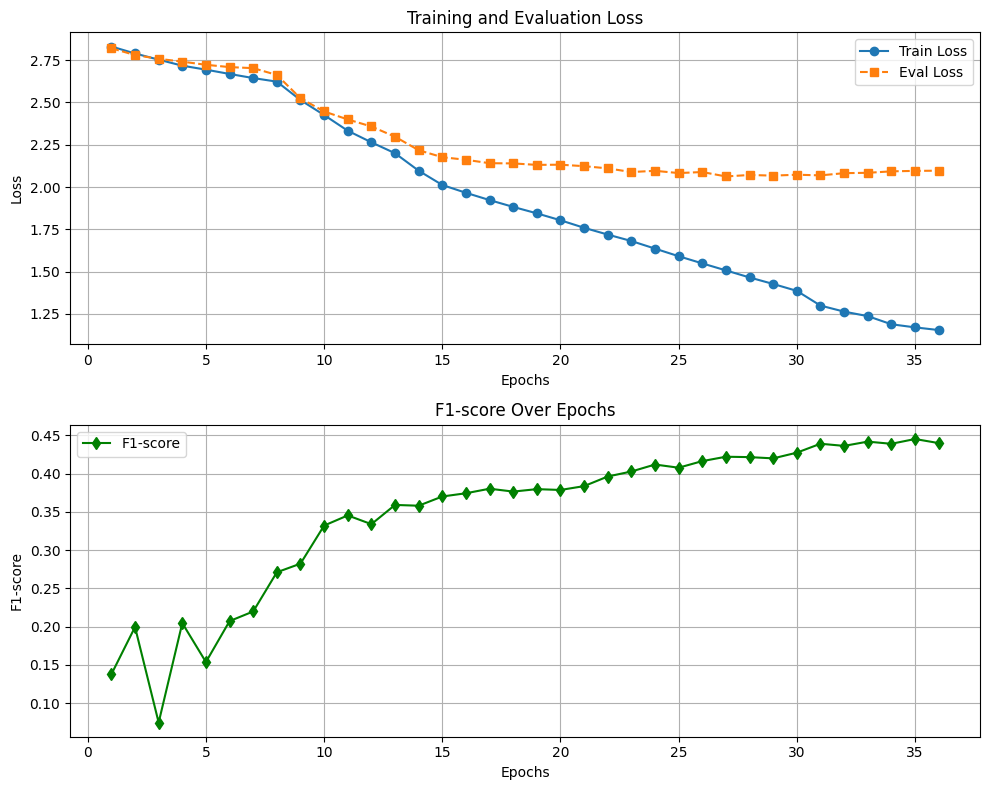

In [55]:
plot_training_history(VQA_model_history)

In [60]:
def test_model(model, question, image_path, ground_truth, idx2word):
    """
    Kiểm tra mô hình VQA với một câu hỏi và một ảnh.

    Parameters:
    - model (torch.nn.Module): Mô hình đã huấn luyện.
    - question (str): Câu hỏi đầu vào.
    - image_path (str): Đường dẫn ảnh.
    - idx2word (dict): Từ điển ánh xạ chỉ mục → từ.

    Returns:
    - str: Câu trả lời dự đoán.
    """
    # Tiền xử lý ảnh
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)  # Thêm batch dimension

    # Tiền xử lý câu hỏi
    question_tensor = text_to_tensor(question, vocab_questions, len_max_question).unsqueeze(0).to(device)  # Hàm mã hóa câu hỏi

    # Dự đoán câu trả lời
    model.eval()
    with torch.no_grad():
        output = model(image_tensor, question_tensor)

    # Chuyển tensor thành câu trả lời văn bản
    predicted_answer = tensor_to_text(output, idx2word)[0]  # Chỉ lấy câu đầu tiên

    # Hiển thị ảnh và kết quả
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Q: {question}\nPredicted answer: {predicted_answer}\nGround Truth: {ground_truth}", fontsize=12)
    plt.show()

    return predicted_answer

In [66]:
def test_random_samples(model, eval_dataframe, idx2word, vocab_questions, len_max_question, device):
    """Lấy ngẫu nhiên 15 mẫu để kiểm tra mô hình."""
    samples = eval_dataframe.sample(n=15)

    for _, row in samples.iterrows():
        question = row['question']
        image_path = '/kaggle/input/visual-question-answering-computer-vision-nlp/dataset/images/' + row['image_id'] + '.png'
        ground_truth = row['answer']  # Changed 'response' to 'answer'

        predicted_answer = test_model(model, question, image_path, ground_truth, idx2word)

        # Hiển thị ảnh và kết quả
        # The test_model function already displays the image and results,
        # so we don't need to repeat it here.
        pass

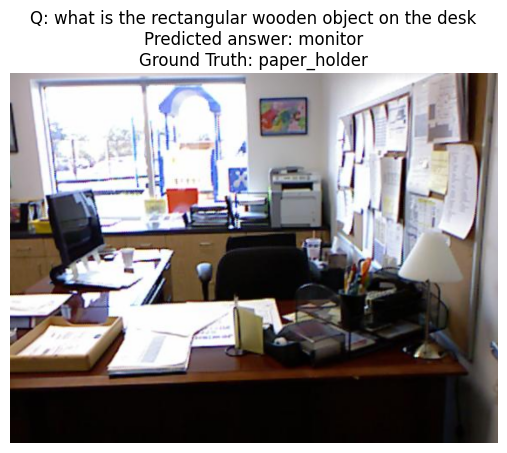

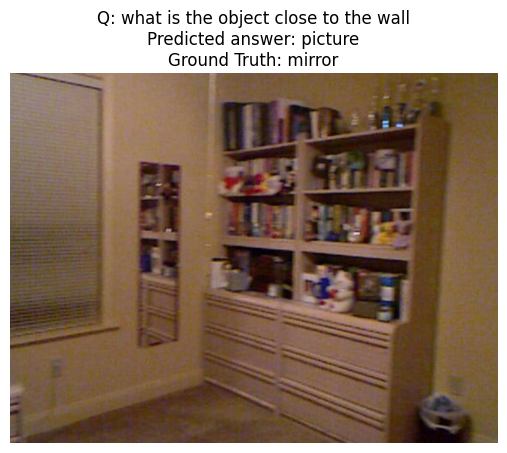

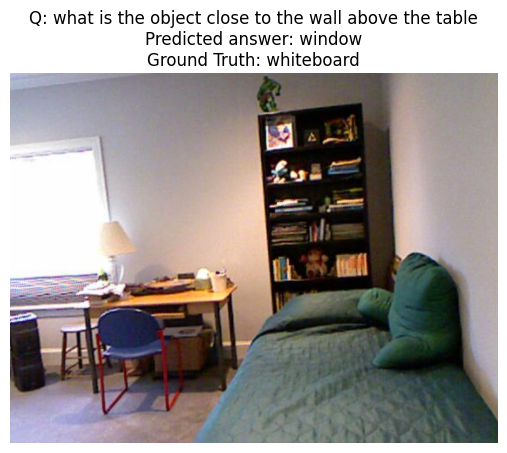

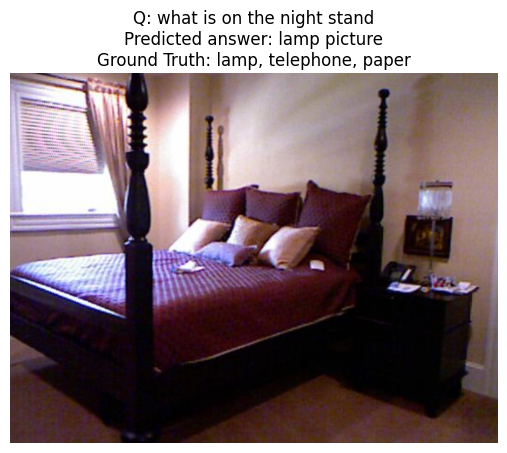

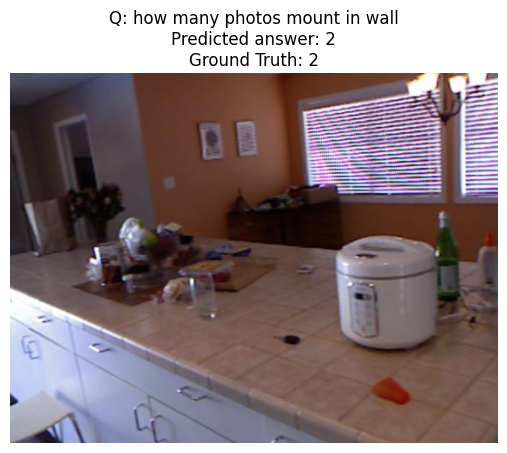

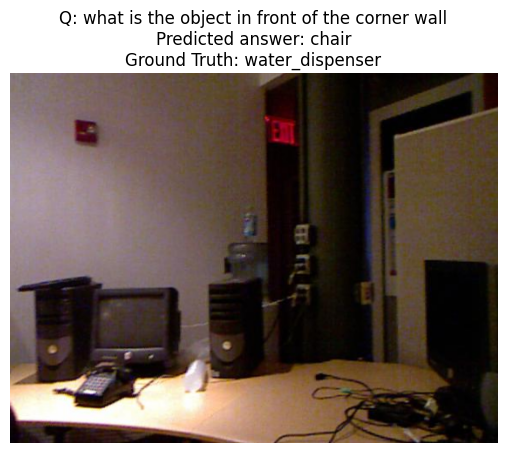

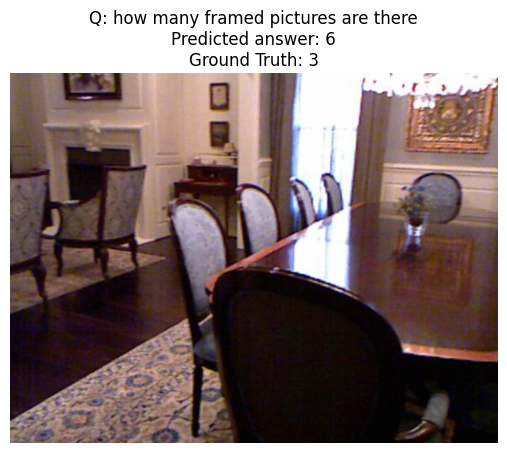

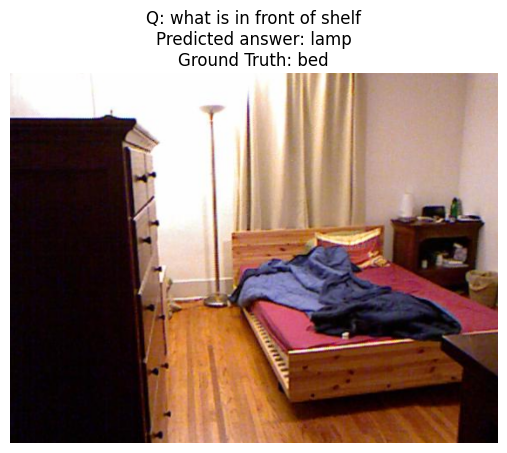

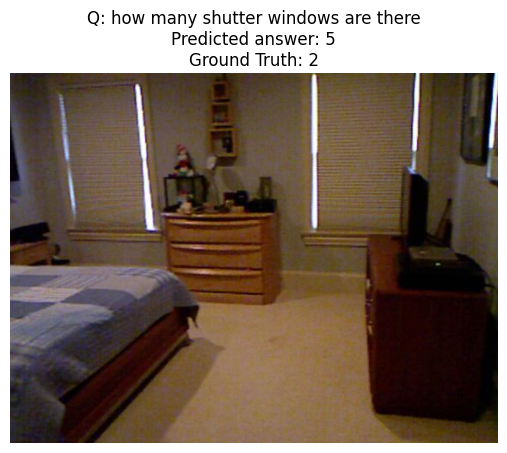

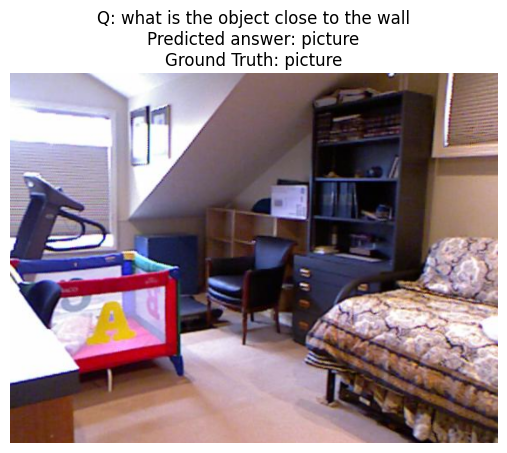

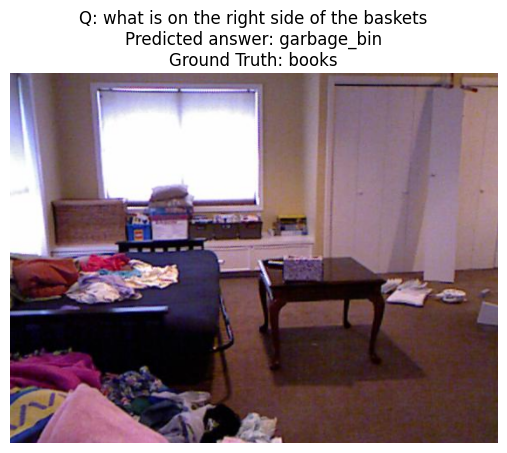

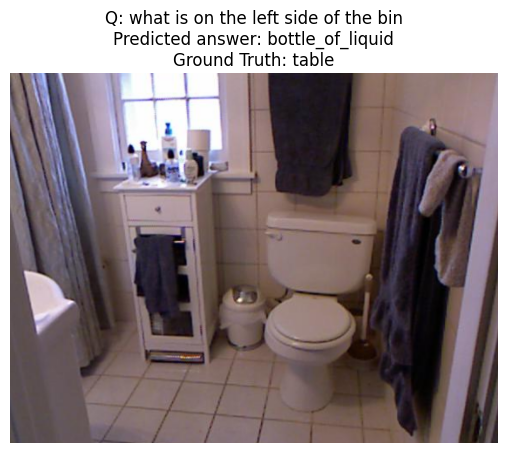

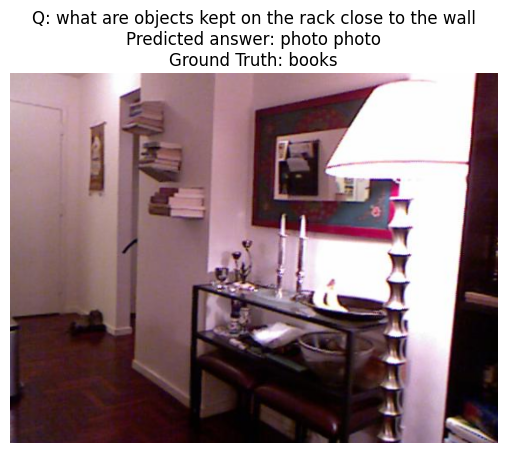

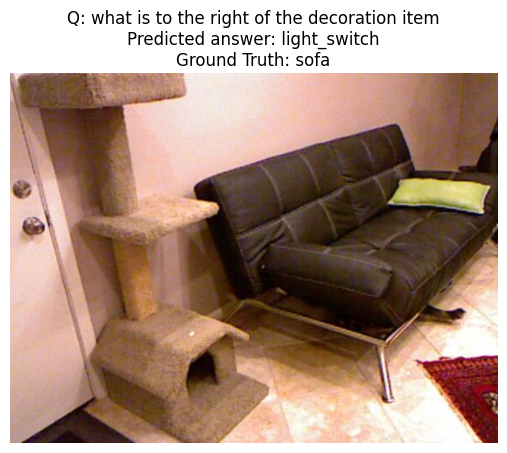

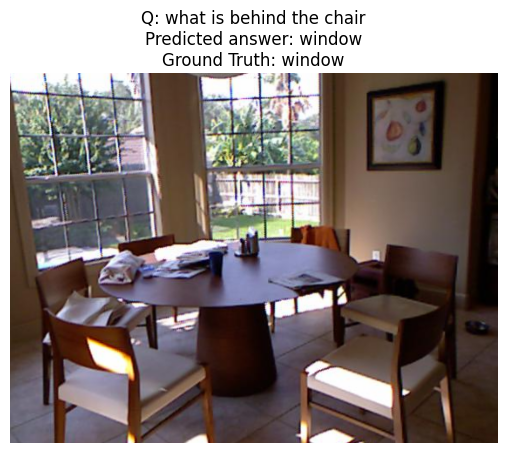

In [67]:
test_random_samples(VQA_model, eval_dataframe, idx2word_answers, vocab_questions, len_max_question, device)